# Traffic Signs Classification
Here i'm gonna be trying to classify traffic signs from crops that are going to be coming for a YOLO detector, since YOLO doesn't have much accuracy, but it detects traffic signs, I'm going to take the bounding box from YOLO, crop the image, and pass it through this classifier.

Let's see if it actually works **;)**

If you want to skip the set-up go to the [Model-2](#Model-2) section.

In [1]:
import os
import cv2
import csv
import glob
import pickle
import random
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 6)

In [2]:
# Data path
data_path = 'data/'

# Pickle files
train_pickle_file = 'train.p' 
valid_pickle_file = 'valid.p'
test_pickle_file = 'test.p'

# Classes file
classes_file = 'classes.csv'

In [3]:
# Load classes
with open(os.path.join(data_path, classes_file), mode='r') as csv_file:
    reader = csv.reader(csv_file)
    classes = {rows[0]:rows[1] for rows in reader}

In [4]:
# Load train data
train_file = open(os.path.join(data_path, train_pickle_file), 'rb')
train_data = pickle.load(train_file)

# Load valid data
valid_file = open(os.path.join(data_path, valid_pickle_file), 'rb')
valid_data = pickle.load(valid_file)

# Load test data
test_file = open(os.path.join(data_path, test_pickle_file), 'rb')
test_data = pickle.load(test_file)

In [5]:
# Data shapes
print('Train data shape:', train_data['features'].shape)
print('Valid data shape:', valid_data['features'].shape)
print('Test data shape:', test_data['features'].shape)

Train data shape: (34799, 32, 32, 3)
Valid data shape: (4410, 32, 32, 3)
Test data shape: (12630, 32, 32, 3)


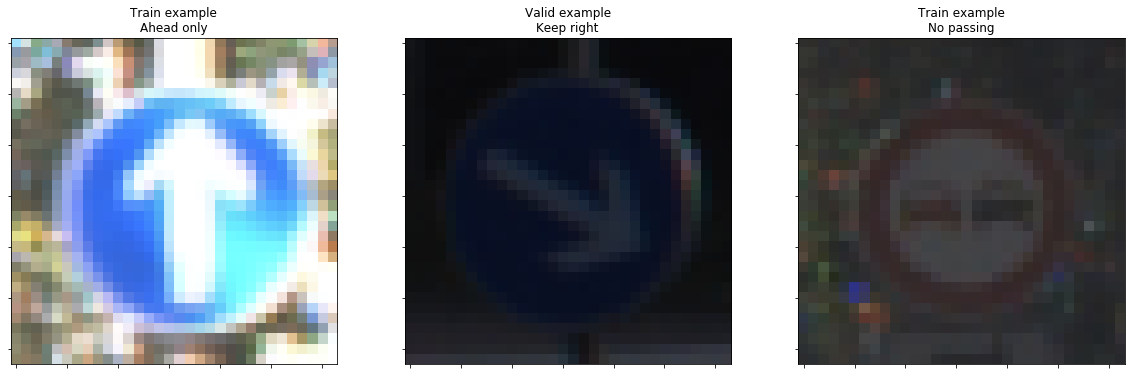

In [6]:
# Verify data
fig = plt.figure()

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

index = random.randrange(0, len(train_data['features']))
ax1.imshow(train_data['features'][index])
ax1.set_title('Train example\n' + classes[str(train_data['labels'][index])])
ax1.set_yticklabels([])
ax1.set_xticklabels([])

index = random.randrange(0, len(valid_data['features']))
ax2.imshow(valid_data['features'][index])
ax2.set_title('Valid example\n' + classes[str(valid_data['labels'][index])])
ax2.set_yticklabels([])
ax2.set_xticklabels([])

index = random.randrange(0, len(test_data['features']))
ax3.imshow(test_data['features'][index])
ax3.set_title('Train example\n' + classes[str(test_data['labels'][index])])
ax3.set_yticklabels([])
ax3.set_xticklabels([])

plt.show()

In [94]:
import keras
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import LeakyReLU
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import MaxPooling2D
from keras.layers import ZeroPadding2D

from keras.optimizers import SGD

In [32]:
# Define image parameters
IMG_SIZE = 32
IMG_DEPTH = 3
NUM_CLASSES = 43 

# Define checkpoints path
CHECKPOINT_PATH = 'checkpoints/'

# Model 2
For this second try, I'm going to be trying the VGG16 architecture from [here](https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3#file-vgg-16_keras-py). 

I had to remove some layers because it wasn't learning, it was stuck.

In [90]:
# Model name
MODEL_NAME = 'model_2'

In [88]:
# Define model parameters
LEARNIG_RATE = 0.001
BATCH_SIZE = 256
EPOCHS = 100

In [115]:
def model_2(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(IMG_SIZE, IMG_SIZE, IMG_DEPTH)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model

In [116]:
# Create model
model = model_2()

In [117]:
# Callbacks
filepath = MODEL_NAME + '-weights-{epoch:02d}-{val_acc:.2f}.hdf5'
folder = os.path.join(CHECKPOINT_PATH, MODEL_NAME)
filepath = os.path.join(folder, filepath)

callbacks = [
                keras.callbacks.ModelCheckpoint(filepath, 
                                                monitor='val_acc', 
                                                verbose=0, 
                                                save_best_only=False, 
                                                save_weights_only=False, 
                                                mode='auto', 
                                                period=1),
                keras.callbacks.TensorBoard(log_dir='./logs', 
                                            histogram_freq=0, 
                                            write_graph=True, 
                                            write_images=False, 
                                            embeddings_freq=0, 
                                            embeddings_layer_names=None, 
                                            embeddings_metadata=None)
            ]

In [118]:
# Compile model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [119]:
# Organize training and testing data
x_train = train_data['features']
y_train = train_data['labels']

x_valid = valid_data['features']
y_valid = valid_data['labels']

x_test = test_data['features']
y_test = test_data['labels']

In [120]:
# Convert labels to one hot encoding
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_valid = keras.utils.to_categorical(y_valid, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [121]:
# Fit model
model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(x_valid, y_valid),
          callbacks=callbacks)

Train on 34799 samples, validate on 4410 samples
Epoch 1/100
34799/34799 [==============================] - 25s - loss: 2.1317 - acc: 0.4694 - val_loss: 0.4213 - val_acc: 0.8825

KeyboardInterrupt: 

In [133]:
# Evaluate model
file_filter = '*.hdf5'
weights_files = glob.glob(os.path.join(folder, file_filter))

data = {}

for weight_file in weights_files:
    # Load weights
    model = model_2(weight_file)
    
    # Compile model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

    # Evaluate model
    score = model.evaluate(x_test, y_test, verbose=0)
    
    data[weight_file] = {'test_loss': score[0], 'test_acc': score[1]}
    
    """
    print('Model weights:', weight_file)
    print('\tTest loss:', score[0])
    print('\tTest accuracy:', score[1])
    print()
    """

Model weights: checkpoints/model_2/model_2-weights-19-0.98.hdf5
	Test loss: 0.205628619596
	Test accuracy: 0.96595407764

Model weights: checkpoints/model_2/model_2-weights-07-0.98.hdf5
	Test loss: 0.192817154581
	Test accuracy: 0.96682501987

Model weights: checkpoints/model_2/model_2-weights-17-0.98.hdf5
	Test loss: 0.207155745581
	Test accuracy: 0.965003958904

Model weights: checkpoints/model_2/model_2-weights-20-0.98.hdf5
	Test loss: 0.204033847553
	Test accuracy: 0.967854315142

Model weights: checkpoints/model_2/model_2-weights-29-0.99.hdf5
	Test loss: 0.2420702543
	Test accuracy: 0.969912905855

Model weights: checkpoints/model_2/model_2-weights-13-0.98.hdf5
	Test loss: 0.171735833535
	Test accuracy: 0.969279493346

Model weights: checkpoints/model_2/model_2-weights-10-0.98.hdf5
	Test loss: 0.202607558958
	Test accuracy: 0.962628661935

Model weights: checkpoints/model_2/model_2-weights-01-0.96.hdf5
	Test loss: 0.249309157785
	Test accuracy: 0.941330166365

Model weights: check

ValueError: You are trying to load a weight file containing 16 layers into a model with 8 layers.

In [138]:
max_acc = 0
max_acc_weights = None

for key in data.keys():
    if data[key]['test_acc'] > max_acc:
        max_acc = data[key]['test_acc']
        max_acc_weights = key

In [139]:
print(max_acc, max_acc_weights)

0.969912905855 checkpoints/model_2/model_2-weights-29-0.99.hdf5


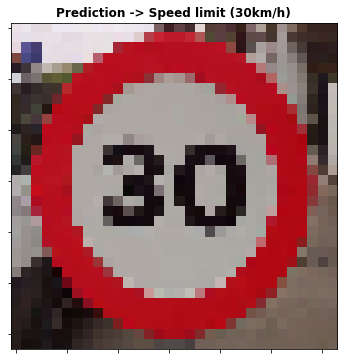

In [140]:
# Test on external image
image_path = 'data/images/1.jpg'
img = cv2.imread(image_path)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = img[...,::-1]

# Predict label for external test image
img_test = np.expand_dims(img, axis=0)
predictions = model.predict(img_test)

class_id = np.argmax(predictions)
class_label = classes[str(class_id)]

# Plot image with class label
ax = plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.imshow(img)
ax.set_title('Prediction -> ' + class_label, fontweight="bold")
plt.show()

In [152]:
import time

# Test on external image
image_path = 'data/images/1.jpg'
img = cv2.imread(image_path)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = img[...,::-1]

# Predict label for external test image
img_test = np.expand_dims(img, axis=0)

start = time.time()

predictions = model.predict(img_test)
class_id = np.argmax(predictions)
class_label = classes[str(class_id)]

end = time.time()

elapsed = end - start

print('Predicted', class_label, 'in', elapsed, 'seconds.')

Predicted Speed limit (30km/h) in 0.00448298454284668 seconds.
